# 0. Imports

In [1]:
# Main go-to imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
import wordcloud


# Extra From Imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

%matplotlib inline
pd.set_option('max_colwidth', 99)

# 1. EDA

In [2]:
df_wot = pd.read_csv('datasets/wot_data.csv')
df_asoiaf = pd.read_csv('datasets/asoiaf_data.csv')

In [3]:
df_wot.head()

,created_utc,title,selftext,subreddit
0,1578368661,"Does anyone know if there is a picture of ""Death is lighter than a feather. Duty, heavier than ...",NaN,WoT
1,1578375127,"Winters heart meaning, quick question.",I'm on book seven and it just described Sammael as having eyes as blue as a winters heart. Is t...,WoT
2,1578381105,What do you think would happen someone who is able to channel would have anphantasia?,If you don’t know what that means it’s the inability to use your mind eye. So when you close yo...,WoT
3,1578393039,"I'm at the end of the semester in college and with a lot of things to do, I can only get back t...",NaN,WoT
4,1578408255,Question about Seanchan Spoilers: All Seanchan,Have you guys ever seen the parallels between the Seanchan and the colonial US. People split of...,WoT


In [4]:
df_wot.isnull().sum()

created_utc       0
title             0
selftext       2020
subreddit         0
dtype: int64

In [5]:
df_asoiaf.head()

,created_utc,title,selftext,subreddit
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,asoiaf
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",asoiaf
2,1579206490,Fancasts for Brienne of Tarth?,[removed],asoiaf
3,1579206863,What if Viserys Targaryen returned to Westeros under a peace banner and swore fealty to Robert ...,[removed],asoiaf
4,1579208246,(Spoilers Extended) What if Viserys Targaryen returned to Westeros under a peace banner and swo...,"In this scenario, Viserys is not mad or cruel and this is before he has encountered the Dothrak...",asoiaf


In [6]:
df_asoiaf.isnull().sum()

created_utc      0
title            0
selftext       891
subreddit        0
dtype: int64

In [7]:
df_comb = pd.concat([df_asoiaf, df_wot])
df_comb.dropna(inplace=True)
df_comb.drop_duplicates(inplace=True)
df_comb.to_csv('datasets/combined.csv',index=False)

In [8]:
df_all = pd.read_csv('datasets/combined.csv')

In [9]:
df_all.shape

(10088, 4)

In [10]:
df_all['subreddit'].value_counts()

asoiaf    5108
WoT       4980
Name: subreddit, dtype: int64

In [11]:
# Taken from Brendan McDonnell's spooky-eda code, modified for project 3 use

def wordclouder_selftext(subreddit, colormap_input): #can also do inferno
    
    wc = wordcloud.WordCloud(max_words=50, width=800, height=400,
                            colormap=colormap_input)
    
    raw_text = df_all.loc[df_all['subreddit'] == subreddit, 'selftext']
    
    return wc.generate(raw_text.str.cat()).to_image()

def wordclouder_title(subreddit, colormap_input): #can also do inferno
    
    wc = wordcloud.WordCloud(max_words=50, width=800, height=400,
                            colormap=colormap_input)
    
    raw_text = df_all.loc[df_all['subreddit'] == subreddit, 'title']
    
    return wc.generate(raw_text.str.cat()).to_image()

def wordclouder_combined(subreddit, colormap_input): #can also do inferno
    
    wc = wordcloud.WordCloud(max_words=50, width=800, height=400,
                            colormap=colormap_input)
    
    raw_text = df_all.loc[df_all['subreddit'] == subreddit, 'title_and_text']
    
    return wc.generate(raw_text.str.cat()).to_image()

In [12]:
df_all.shape

(10088, 4)

In [13]:
df_all.head()

,created_utc,title,selftext,subreddit
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,asoiaf
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",asoiaf
2,1579206490,Fancasts for Brienne of Tarth?,[removed],asoiaf
3,1579206863,What if Viserys Targaryen returned to Westeros under a peace banner and swore fealty to Robert ...,[removed],asoiaf
4,1579208246,(Spoilers Extended) What if Viserys Targaryen returned to Westeros under a peace banner and swo...,"In this scenario, Viserys is not mad or cruel and this is before he has encountered the Dothrak...",asoiaf


In [14]:
df_all.dtypes

created_utc     int64
title          object
selftext       object
subreddit      object
dtype: object

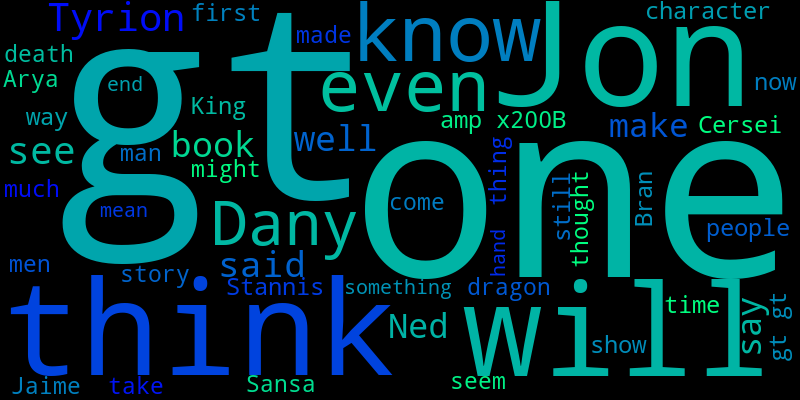

In [15]:
# Asoiaf Wordcloud_selftext
wordclouder_selftext('asoiaf', 'winter')

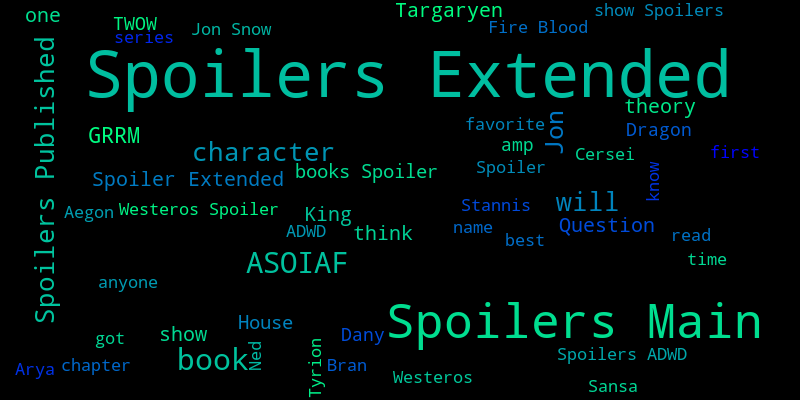

In [16]:
# Asoiaf Wordcloud_title
wordclouder_title('asoiaf', 'winter')

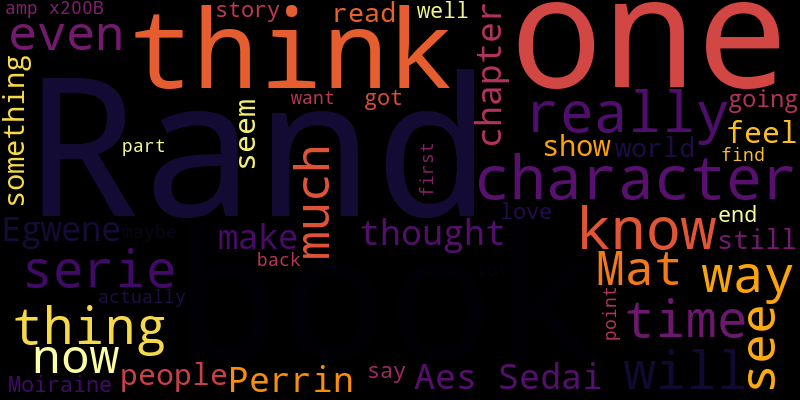

In [17]:
# WoT Wordcloud_selftext
wordclouder_selftext('WoT', 'inferno')

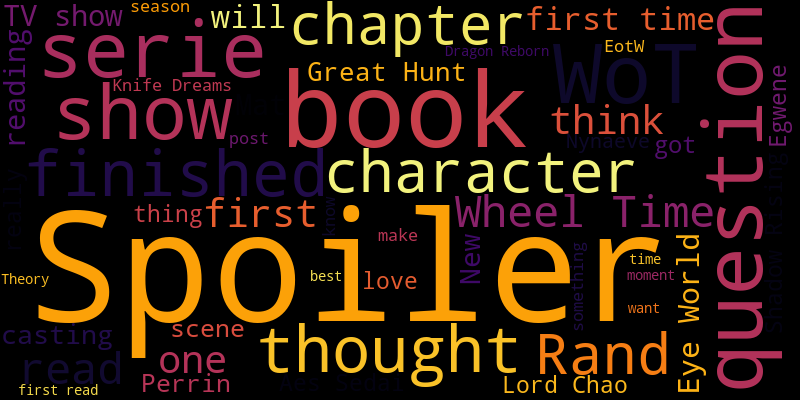

In [18]:
# WoT Wordcloud_title
wordclouder_title('WoT', 'inferno')

In [19]:
df = pd.get_dummies(df_all, columns=['subreddit'], drop_first=True)

In [20]:
df.head()

,created_utc,title,selftext,subreddit_asoiaf
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,1
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",1
2,1579206490,Fancasts for Brienne of Tarth?,[removed],1
3,1579206863,What if Viserys Targaryen returned to Westeros under a peace banner and swore fealty to Robert ...,[removed],1
4,1579208246,(Spoilers Extended) What if Viserys Targaryen returned to Westeros under a peace banner and swo...,"In this scenario, Viserys is not mad or cruel and this is before he has encountered the Dothrak...",1


In [21]:
df['subreddit_asoiaf'].value_counts(normalize=True)

1    0.506344
0    0.493656
Name: subreddit_asoiaf, dtype: float64

In [22]:
custom_stop = list(ENGLISH_STOP_WORDS)

cv = CountVectorizer(stop_words=custom_stop, min_df=6)

df_features = pd.DataFrame(cv.fit_transform(df['title']).todense(),
                          columns = cv.get_feature_names())

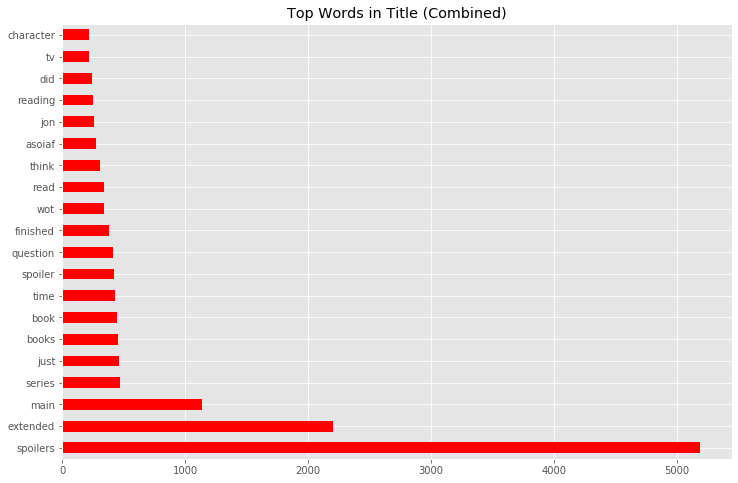

In [67]:
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
df_features.sum().sort_values(ascending=False).head(20).plot.barh(color='red', y=True);
plt.title('Top Words in Title (Combined)');


In [24]:
df_features

,01,10,100,11,12,13,14,15,1st,20,...,wow,write,writing,written,wrong,wrote,year,years,young,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10084,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10085,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df_all

,created_utc,title,selftext,subreddit
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,asoiaf
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",asoiaf
2,1579206490,Fancasts for Brienne of Tarth?,[removed],asoiaf
3,1579206863,What if Viserys Targaryen returned to Westeros under a peace banner and swore fealty to Robert ...,[removed],asoiaf
4,1579208246,(Spoilers Extended) What if Viserys Targaryen returned to Westeros under a peace banner and swo...,"In this scenario, Viserys is not mad or cruel and this is before he has encountered the Dothrak...",asoiaf
...,...,...,...,...
10083,1558598765,Reading Order,"Hi guys!\n\nI'm new to WoT. It's been on my radar for years, but the sheer size and scope of th...",WoT
10084,1558600568,Mat and the Seanchan,\n\nI know I’ll probably get a lot of hate for this because people here seem to adore the Sea...,WoT
10085,1558620344,"For my 34th birthday today, I finished the series. Happy birthday to me! And wow...",That was one of the best series I ever read. Glad I can finally join your ranks and also finall...,WoT
10086,1558625308,Which is the best way to read this saga?,Hello! I recently started reading the Wheel of Time. I finished the Eye of the World yesterday...,WoT


In [26]:
# wot_d = (df_features.loc[df_all['subreddit'] == 'WoT']).copy()

# asoiaf_d = (df_features.loc[df_all['subreddit'] == 'asoiaf']).copy()

asoif_t_d = (df_features.loc[df_all['subreddit'] == 'asoiaf'])
wot_t_d = (df_features.loc[df_all['subreddit'] == 'WoT'])

freq_words = df_features.sum().sort_values(ascending=False).head(20).index


In [27]:
asoif_t_d[freq_words].sum()

spoilers     3898
extended     2203
main         1122
series        112
just          113
books         259
book          138
time           81
spoiler       239
question       99
finished       37
wot             2
read          105
think         196
asoiaf        273
jon           262
reading       102
did           154
tv             35
character     137
dtype: int64

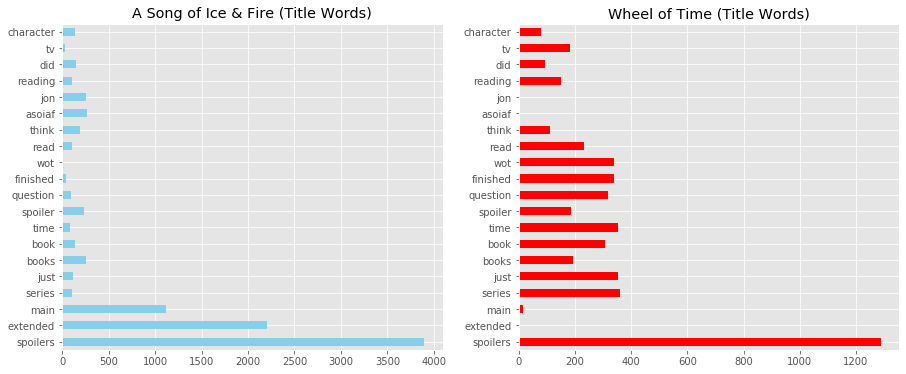

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
plt.style.use('ggplot')

asoif_t_d[freq_words].sum().plot.barh(ax=ax1, title='A Song of Ice & Fire (Title Words)', color = 'skyblue')
wot_t_d[freq_words].sum().plot.barh(ax=ax2, title='Wheel of Time (Title Words)', color='red')

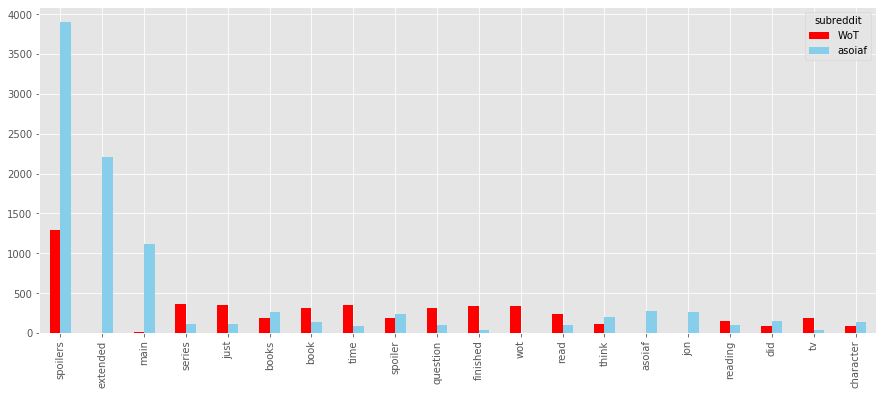

In [68]:
fig, ax = plt.subplots(figsize=(15,6))
plt.style.use('ggplot')

df_features.groupby(df_all['subreddit']).sum()[freq_words].T.plot.bar(ax=ax, color=['red', 'skyblue']);



In [30]:
cv2 = CountVectorizer(stop_words=custom_stop, min_df=6)

df_features2 = pd.DataFrame(cv2.fit_transform(df['selftext']).todense(),
                          columns = cv2.get_feature_names())

In [31]:
asoif_st_d = (df_features2.loc[df_all['subreddit'] == 'asoiaf'])
wot_st_d = (df_features2.loc[df_all['subreddit'] == 'WoT'])

freq_words2 = df_features2.sum().sort_values(ascending=False).head(20).index

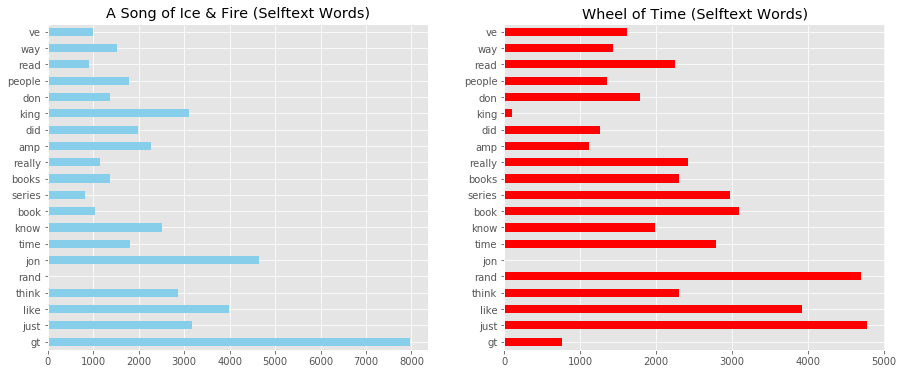

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

asoif_st_d[freq_words2].sum().plot.barh(ax=ax1, title='A Song of Ice & Fire (Selftext Words)', color = 'skyblue')
wot_st_d[freq_words2].sum().plot.barh(ax=ax2, title='Wheel of Time (Selftext Words)', color='red')

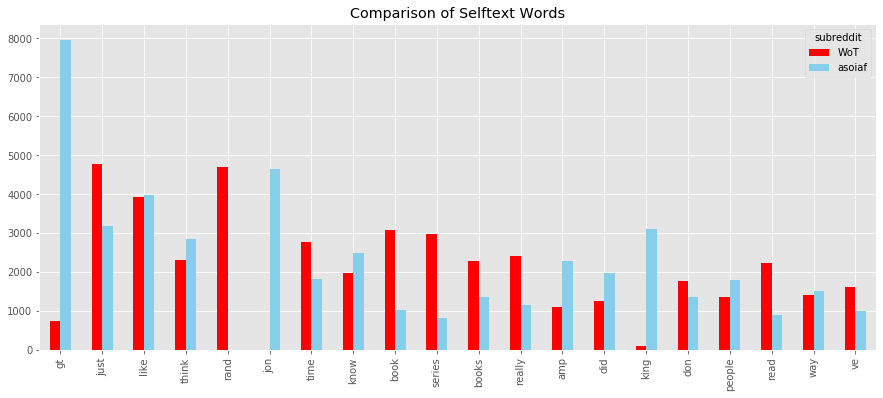

In [69]:
fig, ax = plt.subplots(figsize=(15,6))
plt.style.use('ggplot')
plt.title('Comparison of Selftext Words')

df_features2.groupby(df_all['subreddit']).sum()[freq_words2].T.plot.bar(ax=ax, color=['red', 'skyblue']);

In [50]:
df['title'] + df['selftext'];

In [35]:
df.head(2)

,created_utc,title,selftext,subreddit_asoiaf
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,1
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",1


In [36]:
df_all.head(2)

,created_utc,title,selftext,subreddit
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,asoiaf
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",asoiaf


In [51]:
# Awesome lambda function from user `Russ` @
# https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python

df['title_and_text'] = df[['title', 'selftext']].apply(lambda x: ' '.join(x), axis=1)
df_all['title_and_text'] = df_all[['title', 'selftext']].apply(lambda x: ' '.join(x), axis=1)



In [52]:
df.head(2)

,created_utc,title,selftext,subreddit_asoiaf,title_and_text
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,1,[Spoilers Main] Wildfire looks like. . . I noticed today that the description of wildfire sound...
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",1,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords On a re-read of Storm...


In [53]:
df_all.head(2)

,created_utc,title,selftext,subreddit,title_and_text
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,asoiaf,[Spoilers Main] Wildfire looks like. . . I noticed today that the description of wildfire sound...
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",asoiaf,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords On a re-read of Storm...


In [54]:
cv3 = CountVectorizer(stop_words=custom_stop, min_df=6)

df_features3 = pd.DataFrame(cv3.fit_transform(df['title_and_text']).todense(),
                          columns = cv3.get_feature_names())

In [55]:
asoif_cb_d = (df_features3.loc[df_all['subreddit'] == 'asoiaf'])
wot_cb_d = (df_features3.loc[df_all['subreddit'] == 'WoT'])

freq_words3 = df_features3.sum().sort_values(ascending=False).head(20).index

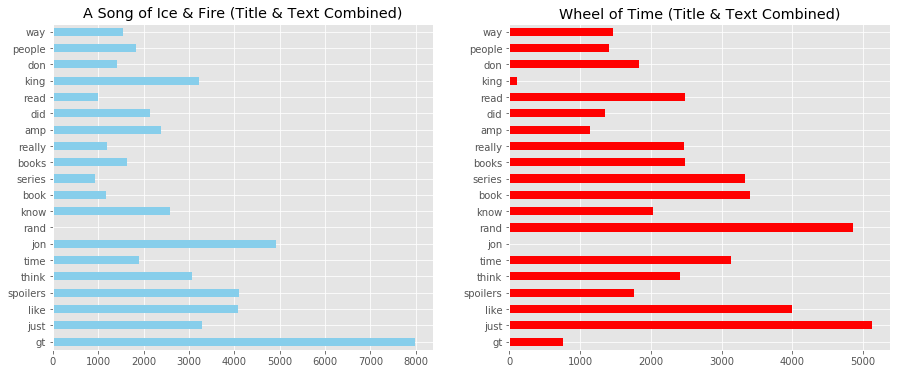

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

asoif_cb_d[freq_words3].sum().plot.barh(ax=ax1, title='A Song of Ice & Fire (Title & Text Combined)', color = 'skyblue')
wot_cb_d[freq_words3].sum().plot.barh(ax=ax2, title='Wheel of Time (Title & Text Combined)', color='red')

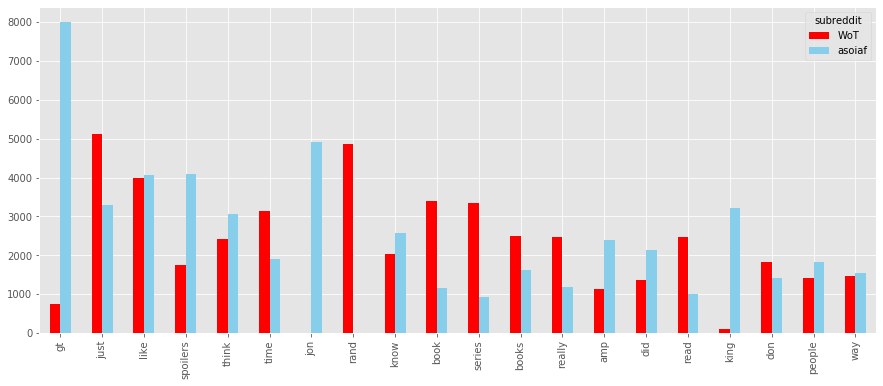

In [57]:
fig, ax = plt.subplots(figsize=(15,6))
plt.style.use('ggplot')

df_features3.groupby(df_all['subreddit']).sum()[freq_words3].T.plot.bar(ax=ax, color=['red', 'skyblue']);

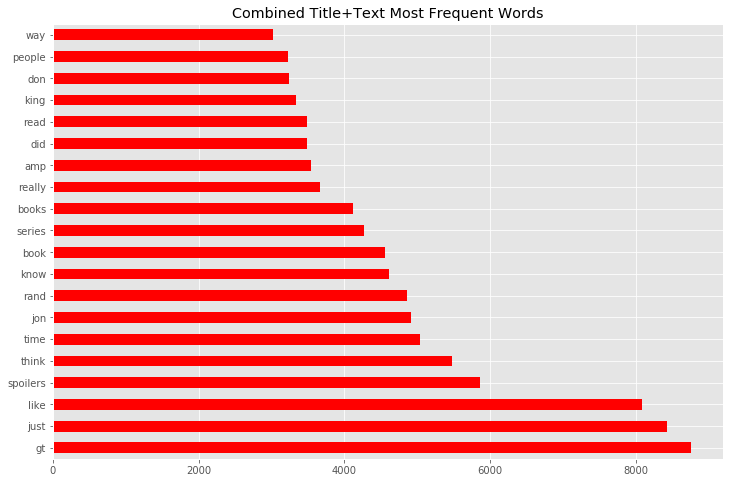

In [58]:
plt.figure(figsize=(12,8))
df_features3.sum().sort_values(ascending=False).head(20).plot.barh(color='red', y=True);

plt.title('Combined Title+Text Most Frequent Words');

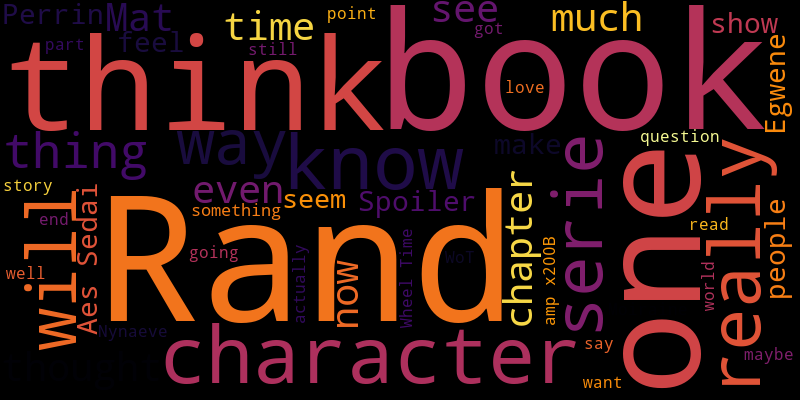

In [59]:
wordclouder_combined('WoT', 'inferno')

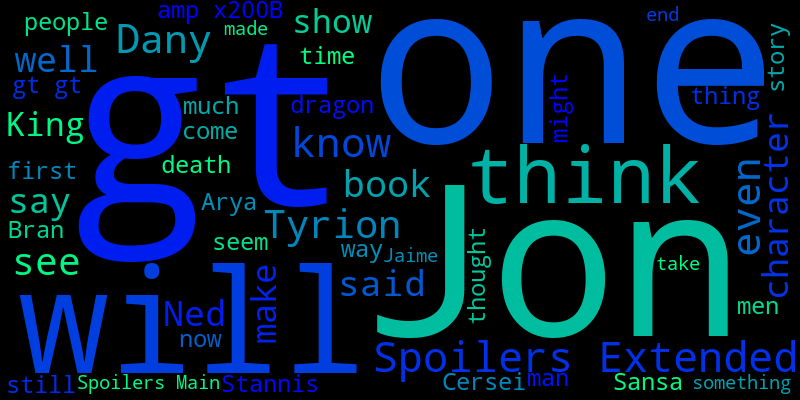

In [60]:
wordclouder_combined('asoiaf', 'winter')

In [63]:
df

,created_utc,title,selftext,subreddit_asoiaf,title_and_text
0,1579203996,[Spoilers Main] Wildfire looks like. . .,I noticed today that the description of wildfire sounds oddly familiar to many brands of antifr...,1,[Spoilers Main] Wildfire looks like. . . I noticed today that the description of wildfire sound...
1,1579205857,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords,"On a re-read of Storm of Swords, I was struck by the passage where Tywin shows Tyrion the two n...",1,(Spoilers Extended) The unusual coloring of Tywin's Valyrian steel swords On a re-read of Storm...
2,1579206490,Fancasts for Brienne of Tarth?,[removed],1,Fancasts for Brienne of Tarth? [removed]
3,1579206863,What if Viserys Targaryen returned to Westeros under a peace banner and swore fealty to Robert ...,[removed],1,What if Viserys Targaryen returned to Westeros under a peace banner and swore fealty to Robert ...
4,1579208246,(Spoilers Extended) What if Viserys Targaryen returned to Westeros under a peace banner and swo...,"In this scenario, Viserys is not mad or cruel and this is before he has encountered the Dothrak...",1,(Spoilers Extended) What if Viserys Targaryen returned to Westeros under a peace banner and swo...
...,...,...,...,...,...
10083,1558598765,Reading Order,"Hi guys!\n\nI'm new to WoT. It's been on my radar for years, but the sheer size and scope of th...",0,"Reading Order Hi guys!\n\nI'm new to WoT. It's been on my radar for years, but the sheer size a..."
10084,1558600568,Mat and the Seanchan,\n\nI know I’ll probably get a lot of hate for this because people here seem to adore the Sea...,0,Mat and the Seanchan \n\nI know I’ll probably get a lot of hate for this because people here ...
10085,1558620344,"For my 34th birthday today, I finished the series. Happy birthday to me! And wow...",That was one of the best series I ever read. Glad I can finally join your ranks and also finall...,0,"For my 34th birthday today, I finished the series. Happy birthday to me! And wow... That was on..."
10086,1558625308,Which is the best way to read this saga?,Hello! I recently started reading the Wheel of Time. I finished the Eye of the World yesterday...,0,Which is the best way to read this saga? Hello! I recently started reading the Wheel of Time. ...


In [62]:
df.to_csv('datasets/model.csv',index=False)